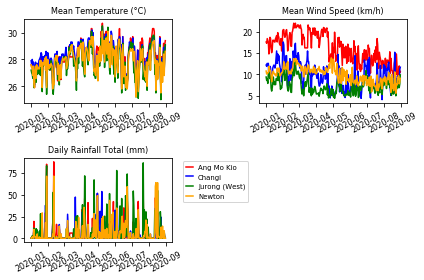

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import glob, os, datetime

area_color = { 
        "amk": 'red', 
        "changi": 'blue', 
        "jurong": 'green',      
        "newton": 'orange'
    }         

def fill_na(df):
    df.fillna(df.mean(), inplace=True)

all_files = glob.glob(os.path.join("data", "*.csv"))
df = pd.concat((pd.read_csv(f, engine='python',  skiprows=1, header=None) for f in all_files))
df = df.reset_index(drop = True)
df.columns = ['Station', 'Year', 'Month', 'Day', 'Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',	'Highest 60 Min Rainfall (mm)',	'Highest 120 Min Rainfall (mm)', 'Mean Temperature (°C)', 'Maximum Temperature (°C)', 'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)', 'Max Wind Speed (km/h)']

for col in df.columns[4:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
  
df['Date'] = pd.to_datetime(df.apply(lambda x: datetime.date(x['Year'], x['Month'], x['Day']), axis=1))
df = df.set_index('Date')
df['Station'] = df['Station'].astype('category')

required_col = ['Mean Temperature (°C)', 'Mean Wind Speed (km/h)', 'Daily Rainfall Total (mm)'] 
areas = ['Ang Mo Kio', 'Changi', 'Jurong (West)', 'Newton']
df_amk = df.loc[df['Station'] == areas[0], required_col]
fill_na(df_amk)
df_changi = df.loc[df['Station'] == areas[1], required_col]
fill_na(df_changi)
df_jurong = df.loc[df['Station'] == areas[2], required_col]
fill_na(df_jurong)
df_newton = df.loc[df['Station'] == areas[3], required_col]
fill_na(df_newton)

fsize = 8
rotate = 28

for i in range(3):
    plt.subplot(2,2,i+1)
    plt.plot(df_amk[required_col[i]], color=area_color['amk'], label=areas[0])
    plt.plot(df_changi[required_col[i]], color=area_color['changi'], label=areas[1])
    plt.plot(df_jurong[required_col[i]], color=area_color['jurong'], label=areas[2])
    plt.plot(df_newton[required_col[i]], color=area_color['newton'], label=areas[3])
    plt.title(required_col[i],fontsize=fsize)
    plt.xticks(rotation=rotate,fontsize=fsize)
    plt.yticks(fontsize=fsize)

plt.legend(fontsize='x-small', bbox_to_anchor=(1.05, 1.0), loc='left',handlelength=1)
plt.tight_layout()
plt.show()

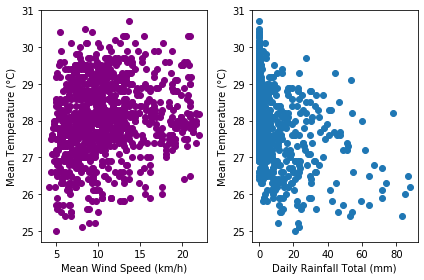

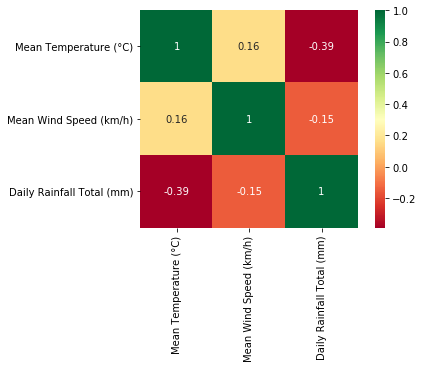

Using Linear Regression:
Mean squared error: 0.8541
Root mean squared error: 0.9242
R2 score: 0.1934
Using Random Forest Regressor:
Mean squared error: 0.8685
Root mean squared error: 0.9319
R2 score: 0.1797


In [2]:
# Predict mean temperature using wind speed and rainfall
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle

df_combined = pd.concat([df_amk, df_changi, df_jurong, df_newton], ignore_index=True)

y = df_combined.iloc[:, 0:1]
X = df_combined.iloc[:, 1:]

plt.subplot(1,2,1)
plt.scatter(X['Mean Wind Speed (km/h)'], y, color='purple')
plt.xlabel("Mean Wind Speed (km/h)")
plt.ylabel("Mean Temperature (°C)")

plt.subplot(1,2,2)
plt.scatter(X['Daily Rainfall Total (mm)'], y)
plt.xlabel("Daily Rainfall Total (mm)")
plt.ylabel("Mean Temperature (°C)")
plt.tight_layout()
plt.show()

sns.heatmap(df_combined.corr(), square=True, cmap='RdYlGn',annot=True)
plt.show()

def save_model(filename, model):
    folder = "ML_models"
    try:
        with open(os.path.join(folder,filename), 'wb') as f:
            pickle.dump(model, f)
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except:
        print ("Unexpected error:", sys.exc_info()[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Using Linear Regression:")
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score: %.4f" % r2_score(y_test, y_pred))
save_model('lr_model.pkl', lr)       


rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
y_rfr_pred = rfr.predict(X_test)
print("Using Random Forest Regressor:")
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_rfr_pred))
print("Root mean squared error: %.4f" % np.sqrt(mean_squared_error(y_test, y_rfr_pred)))
print("R2 score: %.4f" % r2_score(y_test, y_rfr_pred))
save_model('rfr_model.pkl', rfr)
 

[[-1.02540466 -0.05049713]] [29.30892407]
[[108  34]
 [ 42 109]]
              precision    recall  f1-score   support

       False       0.72      0.76      0.74       142
        True       0.76      0.72      0.74       151

    accuracy                           0.74       293
   macro avg       0.74      0.74      0.74       293
weighted avg       0.74      0.74      0.74       293



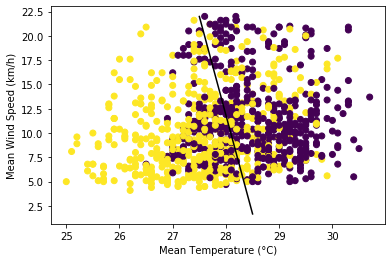

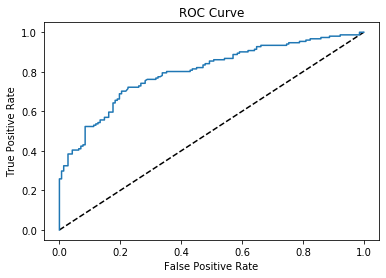

In [3]:
# Predict whether it rained using temperature and wind speed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

df_combined['Rain'] = df_combined['Daily Rainfall Total (mm)'] > 0
X_rain = df_combined[['Mean Temperature (°C)', 'Mean Wind Speed (km/h)']].values
y_rain = df_combined[['Rain']].values
X_rain_train, X_rain_test, y_rain_train, y_rain_test = train_test_split(X_rain, y_rain, test_size=0.3, random_state=42)
logr = LogisticRegression()
logr.fit(X_rain_train, y_rain_train)
print(logr.coef_, logr.intercept_)

y_rain_predict = logr.predict(X_rain_test)
print(confusion_matrix(y_rain_test, y_rain_predict))
print(classification_report(y_rain_test, y_rain_predict))

# Visualisation
plt.scatter(df_combined['Mean Temperature (°C)'], df_combined['Mean Wind Speed (km/h)'], c=df_combined['Rain'])
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Mean Wind Speed (km/h)')
# plot decision boundary 
xx = np.linspace(27.5, 28.5)
yy = (-logr.coef_[0][0] / logr.coef_[0][1]) * xx - (logr.intercept_[0]) / logr.coef_[0][1]
plt.plot(xx, yy, 'k-')
plt.show()

# ROC
y_rain_predict_prob = logr.predict_proba(X_rain_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_rain_test, y_rain_predict_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

save_model('logr_model.pkl', logr)